In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

from pytictoc import TicToc

# FUNCTIONS

In [2]:
################################################### PRE-PROCESSING FUNCTIONS ###################################################
# It should be noted that "age" and "gender" features are removed from the dataset because we are interested in the blood biomarkers

# Function "read_train_data": To read train data
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False
    
def read_train_data(path_train):
    data_df = pd.read_excel(path_train, index_col=[0, 1])
    data_df = data_df.groupby('PATIENT_ID').last() # Group all biomarkers in a single row
    
    lable = data_df['outcome'].values # Labels
    
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.map(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.map(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)

    return data_df


# Function "data_read_and_split": To obtain features dataframe, labels dataframe and features names
# Calculate miss values by colum
def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')

    return col_missing_df
    
def data_read_and_split(path_train, is_dropna=False, sub_cols=None):
    data_df_unna = read_train_data(path_train)
    
    if is_dropna==True:
        data_df_unna = data_df_unna.dropna(subset=sub_cols, how='any')
        
    col_miss_data = col_miss(data_df_unna) # Calculate missing features in train dataset
    col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna) # Calculate the percentage of features missing
    sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col'] # Select features with less than 0.2 missing parts
    
    data_df_sel = data_df_unna[sel_cols].copy() # The copy function extracts the selected feature data without affecting the values of the original data
    cols = list(data_df_sel.columns) # Calculate all features
    cols.remove('age')
    cols.remove('gender')
    cols.remove('Type2')
    cols.append('Type2')
    #data_df_sel2 = data_df_sel[cols] # Construct the dataframe that removes the above features
    
    #data_df_unna = pd.DataFrame() # Construct a new dataframe
    #data_df_unna = data_df_sel2 # Similar to the copy method, create a new variable, the modification will not affect the original value
    data_df_unna = data_df_unna.fillna(-1) # Add -1 to missing values
    
    x_col = cols[:-1] # Obtain the feature names, from the first column to the penultimate column
    y_col = cols[-1] # Obtain the label names
    X_data = data_df_unna[x_col] # 375 feature data
    Y_data = data_df_unna[y_col] # 375 label data

    return X_data,Y_data,x_col


# Function "outliers_iqr": To detect and remove outliers using IQR method
def outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    # Keep only non-outliers
    non_outliers = (column >= lower_bound) & (column <= upper_bound)
    return outliers,non_outliers

################################################ FEATURES SELECTION FUNCTIONS ##################################################
def StratifiedKFold_func_with_features_sel(x, y, Num_iter=100, score_type = 'auc'):
    # Hierarchical k-fold cross-validation
    acc_v = []
    acc_t = []
    
    # K-fold 100 times
    for i in range(Num_iter):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i) # Each fold is random random_state=i
        
        for tr_idx, te_idx in skf.split(x,y):
            x_tr = x[tr_idx, :]
            y_tr = y[tr_idx]
            x_te = x[te_idx, :]
            y_te = y[te_idx]
            
            # Define the model hyperparameters
            model = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,reg_alpha=1)
            # Model fit
            model.fit(x_tr, y_tr)
            pred = model.predict(x_te)
            train_pred = model.predict(x_tr)
            
            # Note that L here with the predicted label value rather than the predicted probability of the AUC, the reason is that this paper focuses on predicting the distinction between life and death, 
            # the use of predicted labels is equivalent to the validation of the model in the case of the threshold is determined to be 0.5, its AUC threshold value is the same as that of the model, but it is not the same as the predicted label.
            ## The AUC threshold split point can be regarded as respectively in 1, 0.5, 0, so that more responsive to the differentiation performance of the features of the difference, to find out the features that can have the contribution of differentiation.
            if score_type == 'auc':
                acc_v.append(roc_auc_score(y_te, pred))
                acc_t.append(roc_auc_score(y_tr, train_pred))
            else:
                acc_v.append(f1_score(y_te, pred))
                acc_t.append(f1_score(y_tr, train_pred))    
    #  Return the mean
    return [np.mean(acc_t), np.mean(acc_v), np.std(acc_t), np.std(acc_v)]


def features_selection(X_data, Y_data, x_col):
    import_feature = pd.DataFrame() # Dataframe for storing feature importance information
    import_feature['col'] = x_col
    import_feature['xgb'] = 0

    x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42) # Each trial randomly divides the 375 data into 0.7 training set and 0.3 test set, noting that random random_state=i
    # Note: The reason for this method is that it was chosen due to the small amount of samples available, in order to generate different sets of training samples, which makes the importance ranking of features more stable.
    # By generating different samples with different random seeds each time, the effect of a small number of sample anomalies on the importance of features can be suppressed to a certain extent.

    # Define the model hyperparameters
    model = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,reg_lambda=1,n_estimators=150,subsample=0.9,colsample_bytree=0.9)
    model.fit(x_train, y_train)

    # Accumulate feature importance
    import_feature['xgb'] = import_feature['xgb']+model.feature_importances_/100
    # Sort features in descending order of importance
    import_feature = import_feature.sort_values(axis=0, ascending=False, by='xgb')

    # Get the importance values for the top 10 important features
    import_feature_cols = import_feature['col'].values[:10]

    # Draw the feature pyramid
    num_i = 1
    val_score_old = 0
    val_score_new = 0.01
    while val_score_new > val_score_old:
        val_score_old = val_score_new
        # Take the features in order of importance
        x_col = import_feature_cols[:num_i]
        print('Input features to the model:', x_col)

        X_data_fp = X_data[x_col]#.values

        ## Cross-validation
        print('5-Fold CV:')
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func_with_features_sel(X_data_fp.values,Y_data.values)
        print("Train AUC-score is %.4f ; Validation AUC-score is %.4f" % (acc_train,acc_val))
        print("Train AUC-score-std is %.4f ; Validation AUC-score-std is %.4f" % (acc_train_std,acc_val_std))
        val_score_new = acc_val
        num_i += 1

    print('Selected features:',x_col[:-1])
    return import_feature


############################################## HYPERPARAMETERS SELECTION FUNCTION ##############################################
# Function "best_hyperparameters": To achieve optimal performance for a model
def best_hyperparameters(X_data,Y_data,params,model):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
    
    # Scoring metrics
#    scoring = {
#        'accuracy': make_scorer(accuracy_score),
#        'precision': make_scorer(precision_score),
#        'recall': make_scorer(recall_score),
#        'f1': make_scorer(f1_score),
#        'auc_roc': make_scorer(roc_auc_score),
#        'auc_pr': make_scorer(average_precision_score)
#    }
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy',cv=5)
#    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, refit='f1', cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Evaluate the model with the best hyperparameters on the test set
#    best_model = grid_search.best_estimator_
#    y_pred = best_model.predict(X_test)

    # Print the metrics
    print('The best hyperparameters for this model are: ', best_params)
#    print("\nMetrics")
#    print("Accuracy:", accuracy_score(y_test, y_pred))
#    print("Precision:", precision_score(y_test, y_pred, zero_division=1))
#    print("Recall:", recall_score(y_test, y_pred))
#    print("F1 Score:", f1_score(y_test, y_pred))
#    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
#    print("AUC-PR:", average_precision_score(y_test, y_pred))
    
    return


################################################### MODEL SELECTION FUNCTIONS ##################################################
def StratifiedKFold_func(x, y, model, Num_iter=100, score_type ='auc'):
    # Model k-folds outside the loop
    # Layered k-fold cross validation
    acc_v = []
    acc_t = []
    
    for i in range(Num_iter):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        for tr_idx, te_idx in skf.split(x,y):
            x_tr = x[tr_idx, :]
            y_tr = y[tr_idx]
            x_te = x[te_idx, :]
            y_te = y[te_idx]

            model.fit(x_tr, y_tr)
            pred = model.predict(x_te)
            train_pred = model.predict(x_tr)

            pred_Proba = model.predict_proba(x_te)[:,1]
            train_pred_Proba = model.predict_proba(x_tr)[:,1]

            if score_type == 'auc':
                acc_v.append(roc_auc_score(y_te, pred_Proba))
                acc_t.append(roc_auc_score(y_tr, train_pred_Proba))
            
            elif score_type == 'precision':
                acc_v.append(precision_score(y_te, pred))
                acc_t.append(precision_score(y_tr, train_pred))
                
            elif score_type == 'recall':
                acc_v.append(recall_score(y_te, pred))
                acc_t.append(recall_score(y_tr, train_pred))
            
            else:
                acc_v.append(f1_score(y_te, pred))
                acc_t.append(f1_score(y_tr, train_pred))
                

    return [np.mean(acc_t), np.mean(acc_v), np.std(acc_t), np.std(acc_v)]


def show_confusion_matrix(validations, predictions, title):
    #print(classification_report(validations, predictions, target_names=['Survival', 'Death']))
    matrix = metrics.confusion_matrix(validations, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Survival', 'Death'])
    cm_display.plot()
    plt.title(title)
    plt.show()


def Compare_with_other_method(X_data,Y_data,cols=None):
    # Read dataset (obtained by removing samples where columns are all empty)
    x_np = X_data
    y_np = Y_data
    X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.3, random_state=6)

    # Define the algorithm under full feature
    tree_clf = DecisionTreeClassifier(random_state=0,max_depth=None,min_samples_leaf=4,min_samples_split=2)
    rf_clf = RandomForestClassifier(random_state=0,max_depth=None,min_samples_leaf=2,min_samples_split=2,n_estimators=150)
    lr_clf = LogisticRegression(random_state=0,C=0.1,solver='lbfgs',max_iter=10000)
    xgb_clf = XGBClassifier(random_state=0,colsample_bytree=0.8,learning_rate=0.05,max_depth=2,n_estimators=150)

    Num_iter = 100
    i = 0
    labels_names = []
    Model_name = ['Decision tree with all features','Random Forest with all features','Logistic regression with all features','Multi-tree XGBoost with all features',]
    
    pred_val = []
    
    for model in [tree_clf,rf_clf,lr_clf,xgb_clf]:
        print('Model:'+ Model_name[i])
        
        t = TicToc()
        t.tic() #Start timer
        
        # k-fold with f1 evaluations
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func(x_np.values, y_np.values, model, Num_iter, score_type ='f1')
        print('F1-score of Train:%.6f with std:%.4f \nF1-score of Validation:%.4f with std:%.6f '%(acc_train,acc_train_std,acc_val,acc_val_std))
        
        # k-fold with auc's evaluation
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func(x_np.values, y_np.values, model, Num_iter, score_type ='auc')
        print('AUC of Train:%.6f with std:%.4f \nAUC of Validation:%.6f with std:%.4f '%(acc_train,acc_train_std,acc_val,acc_val_std))

        # k-fold with precission evaluations
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func(x_np.values, y_np.values, model, Num_iter, score_type ='precision')
        print('Precision of Train:%.6f with std:%.4f \nPrecision of Validation:%.4f with std:%.6f '%(acc_train,acc_train_std,acc_val,acc_val_std))
        
        # k-fold with recall evaluations
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func(x_np.values, y_np.values, model, Num_iter, score_type ='recall')
        print('Recall of Train:%.6f with std:%.4f \nRecall of Validation:%.4f with std:%.6f '%(acc_train,acc_train_std,acc_val,acc_val_std))
    
        t.toc() #Time elapsed since t.tic()
        print('\n')
        
        # Plots
        model.fit(X_train,y_train)
        show_confusion_matrix(y_train, model.predict(X_train), 'Train set')
        show_confusion_matrix(y_val, model.predict(X_val), 'Validation set')
        
        pred_train_probe = model.predict_proba(X_train)[:,1]
        pred_val_probe = model.predict_proba(X_val)[:,1]
        pred_val.append(pred_val_probe)
        
        i = i+1
    
    return y_val, pred_val, Model_name


####################################################### PLOTTING FUNCTION ######################################################
def plot_roc(labels, predict_prob, Model_name_i, fig, labels_name, k):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    #line_list = ['--','-']
    #ax = fig.add_subplot(111)
    plt.title('ROC', fontsize=20)
    plt.plot(false_positive_rate,true_positive_rate,linewidth=1+(1-k/5), label=Model_name_i+' AUC = %0.4f'% roc_auc)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.xlabel('FPR', fontsize=20)
    labels_name.append(Model_name_i+' AUC = %0.4f'% roc_auc)
    return labels_name

# MAIN SCRIPT

## STEP 1: Dataset analysis

In [3]:
path_train = 'C:/Users/helen/Documentos/UT/1B/Data Science - Repair/Project/2.Data/time_series_375_preprocess_en.xlsx'
X_data_all_features,Y_data,x_col = data_read_and_split(path_train, is_dropna=False, sub_cols=None)

In [4]:
# Outliers detection & removal
# Create a new DataFrame without outliers
X_non_outliers = X_data_all_features.copy()  # Create a copy of the original DataFrame
Y_non_outliers = Y_data.copy()

# Loop through each column in the DataFrame
for column in X_data_all_features.columns:
    # Detect and remove outliers in the current column
    outliers,non_outliers = outliers_iqr(X_data_all_features[column])
    
    # Update the DataFrame to keep only non-outliers
    X_non_outliers = X_non_outliers.loc[non_outliers]
    Y_non_outliers = Y_non_outliers.loc[non_outliers]
    
    # Print information about outliers in the current column
    num_outliers = outliers.sum()
    print(f"Column '{column}' has {num_outliers} outliers.")

Column 'Red blood cell count' has 54 outliers.
Column 'White blood cell count' has 23 outliers.
Column 'hematocrit' has 26 outliers.
Column 'globulin' has 26 outliers.
Column 'mean corpuscular hemoglobin concentration' has 28 outliers.
Column 'monocytes count' has 35 outliers.
Column 'Lactate dehydrogenase' has 27 outliers.
Column 'Urea' has 35 outliers.
Column 'lymphocyte count' has 2 outliers.
Column 'γ-glutamyl transpeptidase' has 31 outliers.
Column 'Eosinophil count' has 32 outliers.
Column 'creatinine' has 45 outliers.
Column 'neutrophils count' has 18 outliers.
Column 'Direct bilirubin' has 36 outliers.
Column 'HCO3-' has 28 outliers.
Column 'Uric acid' has 18 outliers.
Column 'aspartate aminotransferase' has 37 outliers.
Column 'mean corpuscular volume' has 33 outliers.
Column 'Total cholesterol' has 25 outliers.
Column '(%)lymphocyte' has 0 outliers.
Column 'Platelet count' has 2 outliers.
Column 'eosinophils(%)' has 14 outliers.
Column 'albumin' has 19 outliers.
Column 'basop

In [5]:
# Print information about the new DataFrame without outliers
print("Original DataFrame shape:", X_data_all_features.shape)
print("Total outputs in the DataFrame with outliers", Y_data.value_counts())
print("DataFrame shape without outliers:", X_non_outliers.shape)
print("Total outputs in the DataFrame without outliers", Y_non_outliers.value_counts())

Original DataFrame shape: (375, 53)
Total outputs in the DataFrame with outliers Type2
0.0    201
1.0    174
Name: count, dtype: int64
DataFrame shape without outliers: (111, 53)
Total outputs in the DataFrame without outliers Type2
0.0    87
1.0    24
Name: count, dtype: int64


## Step 2. Hyperparameter selection

In [6]:
# Model 1. Decision Tree
dt_params = {
    'max_depth': [None, 4, 6, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model = DecisionTreeClassifier(random_state=0)
best_hyperparameters(X_data_all_features,Y_data,dt_params,dt_model)

The best hyperparameters for this model are:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [7]:
# Model 2. Random Forest
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=0)
best_hyperparameters(X_data_all_features,Y_data,rf_params,rf_model)

The best hyperparameters for this model are:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [8]:
# Model 3. Logistic Regression
lr_params = {
    'C': [0.1, 1, 10, 20]
}

lr_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
best_hyperparameters(X_data_all_features,Y_data,lr_params,lr_model)

The best hyperparameters for this model are:  {'C': 0.1}


In [9]:
# Model 4. Multi-tree XGBoost
xgb_params = {
    'n_estimators': [50, 150, 200],
    'max_depth': [2, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    #'subsample': [1.0, 1.2, 1.5],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_model = xgb.XGBClassifier(random_state=0)
best_hyperparameters(X_data_all_features,Y_data,xgb_params,xgb_model)

The best hyperparameters for this model are:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}


## Step 3. Model results

Model:Decision tree with all features
F1-score of Train:0.963065 with std:0.0065 
F1-score of Validation:0.9152 with std:0.034430 
AUC of Train:0.996753 with std:0.0009 
AUC of Validation:0.961937 with std:0.0212 
Precision of Train:0.954530 with std:0.0193 
Precision of Validation:0.9133 with std:0.044053 
Recall of Train:0.972615 with std:0.0229 
Recall of Validation:0.9212 with std:0.063384 
Elapsed time is 25.044893 seconds.




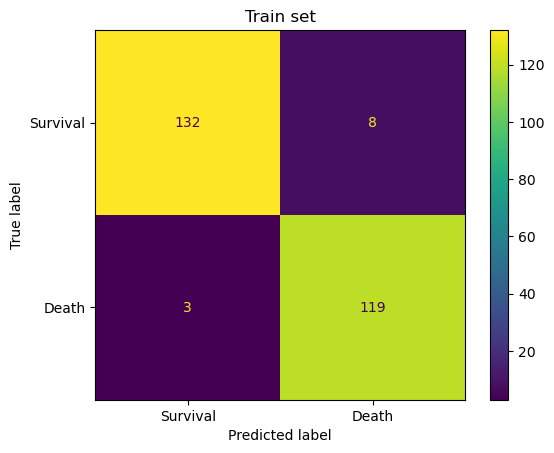

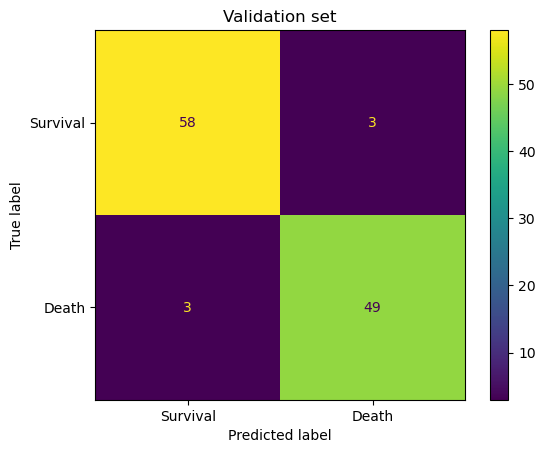

Model:Random Forest with all features
F1-score of Train:0.982271 with std:0.0035 
F1-score of Validation:0.9578 with std:0.022620 
AUC of Train:0.998963 with std:0.0003 
AUC of Validation:0.992889 with std:0.0060 
Precision of Train:0.966028 with std:0.0085 
Precision of Validation:0.9396 with std:0.034644 
Recall of Train:0.999152 with std:0.0055 
Recall of Validation:0.9781 with std:0.030684 
Elapsed time is 890.258898 seconds.




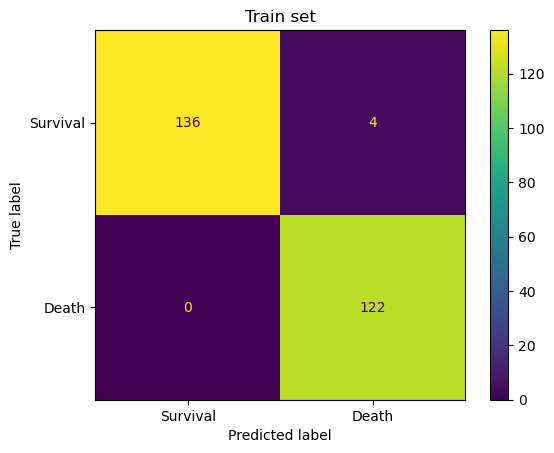

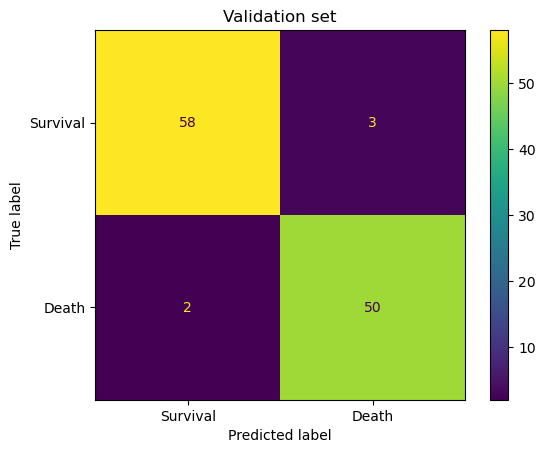

Model:Logistic regression with all features
F1-score of Train:0.980302 with std:0.0047 
F1-score of Validation:0.9330 with std:0.026167 
AUC of Train:0.998919 with std:0.0003 
AUC of Validation:0.973258 with std:0.0192 
Precision of Train:0.964976 with std:0.0082 
Precision of Validation:0.9265 with std:0.037695 
Recall of Train:0.996179 with std:0.0053 
Recall of Validation:0.9417 with std:0.043654 
Elapsed time is 337.638979 seconds.




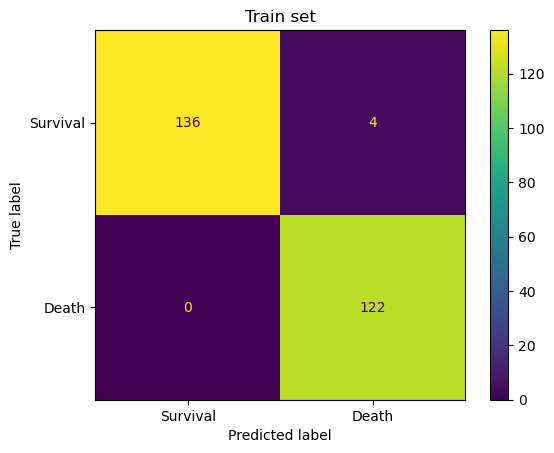

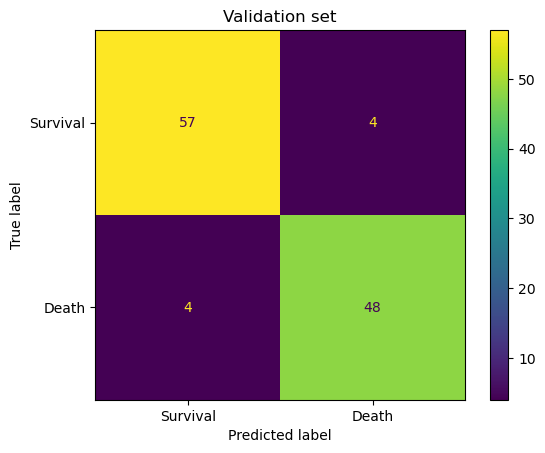

Model:Multi-tree XGBoost with all features
F1-score of Train:0.983126 with std:0.0032 
F1-score of Validation:0.9595 with std:0.023223 
AUC of Train:0.999140 with std:0.0002 
AUC of Validation:0.994209 with std:0.0058 
Precision of Train:0.967189 with std:0.0072 
Precision of Validation:0.9451 with std:0.034576 
Recall of Train:0.999642 with std:0.0033 
Recall of Validation:0.9756 with std:0.030458 
Elapsed time is 160.619857 seconds.




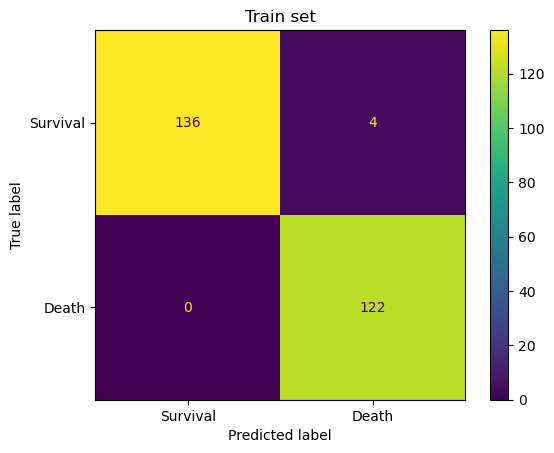

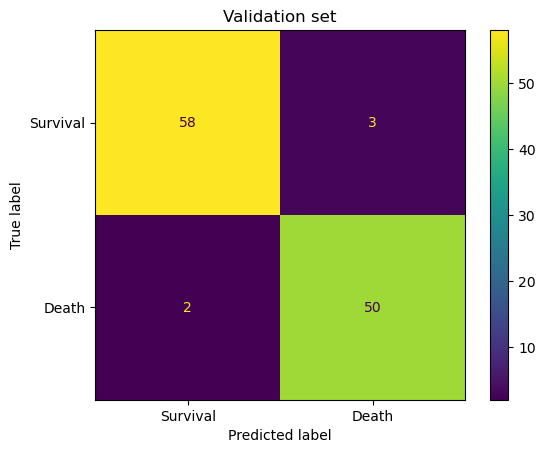

In [10]:
y_val,pred_val,Model_name = Compare_with_other_method(X_data_all_features,Y_data,cols=None)

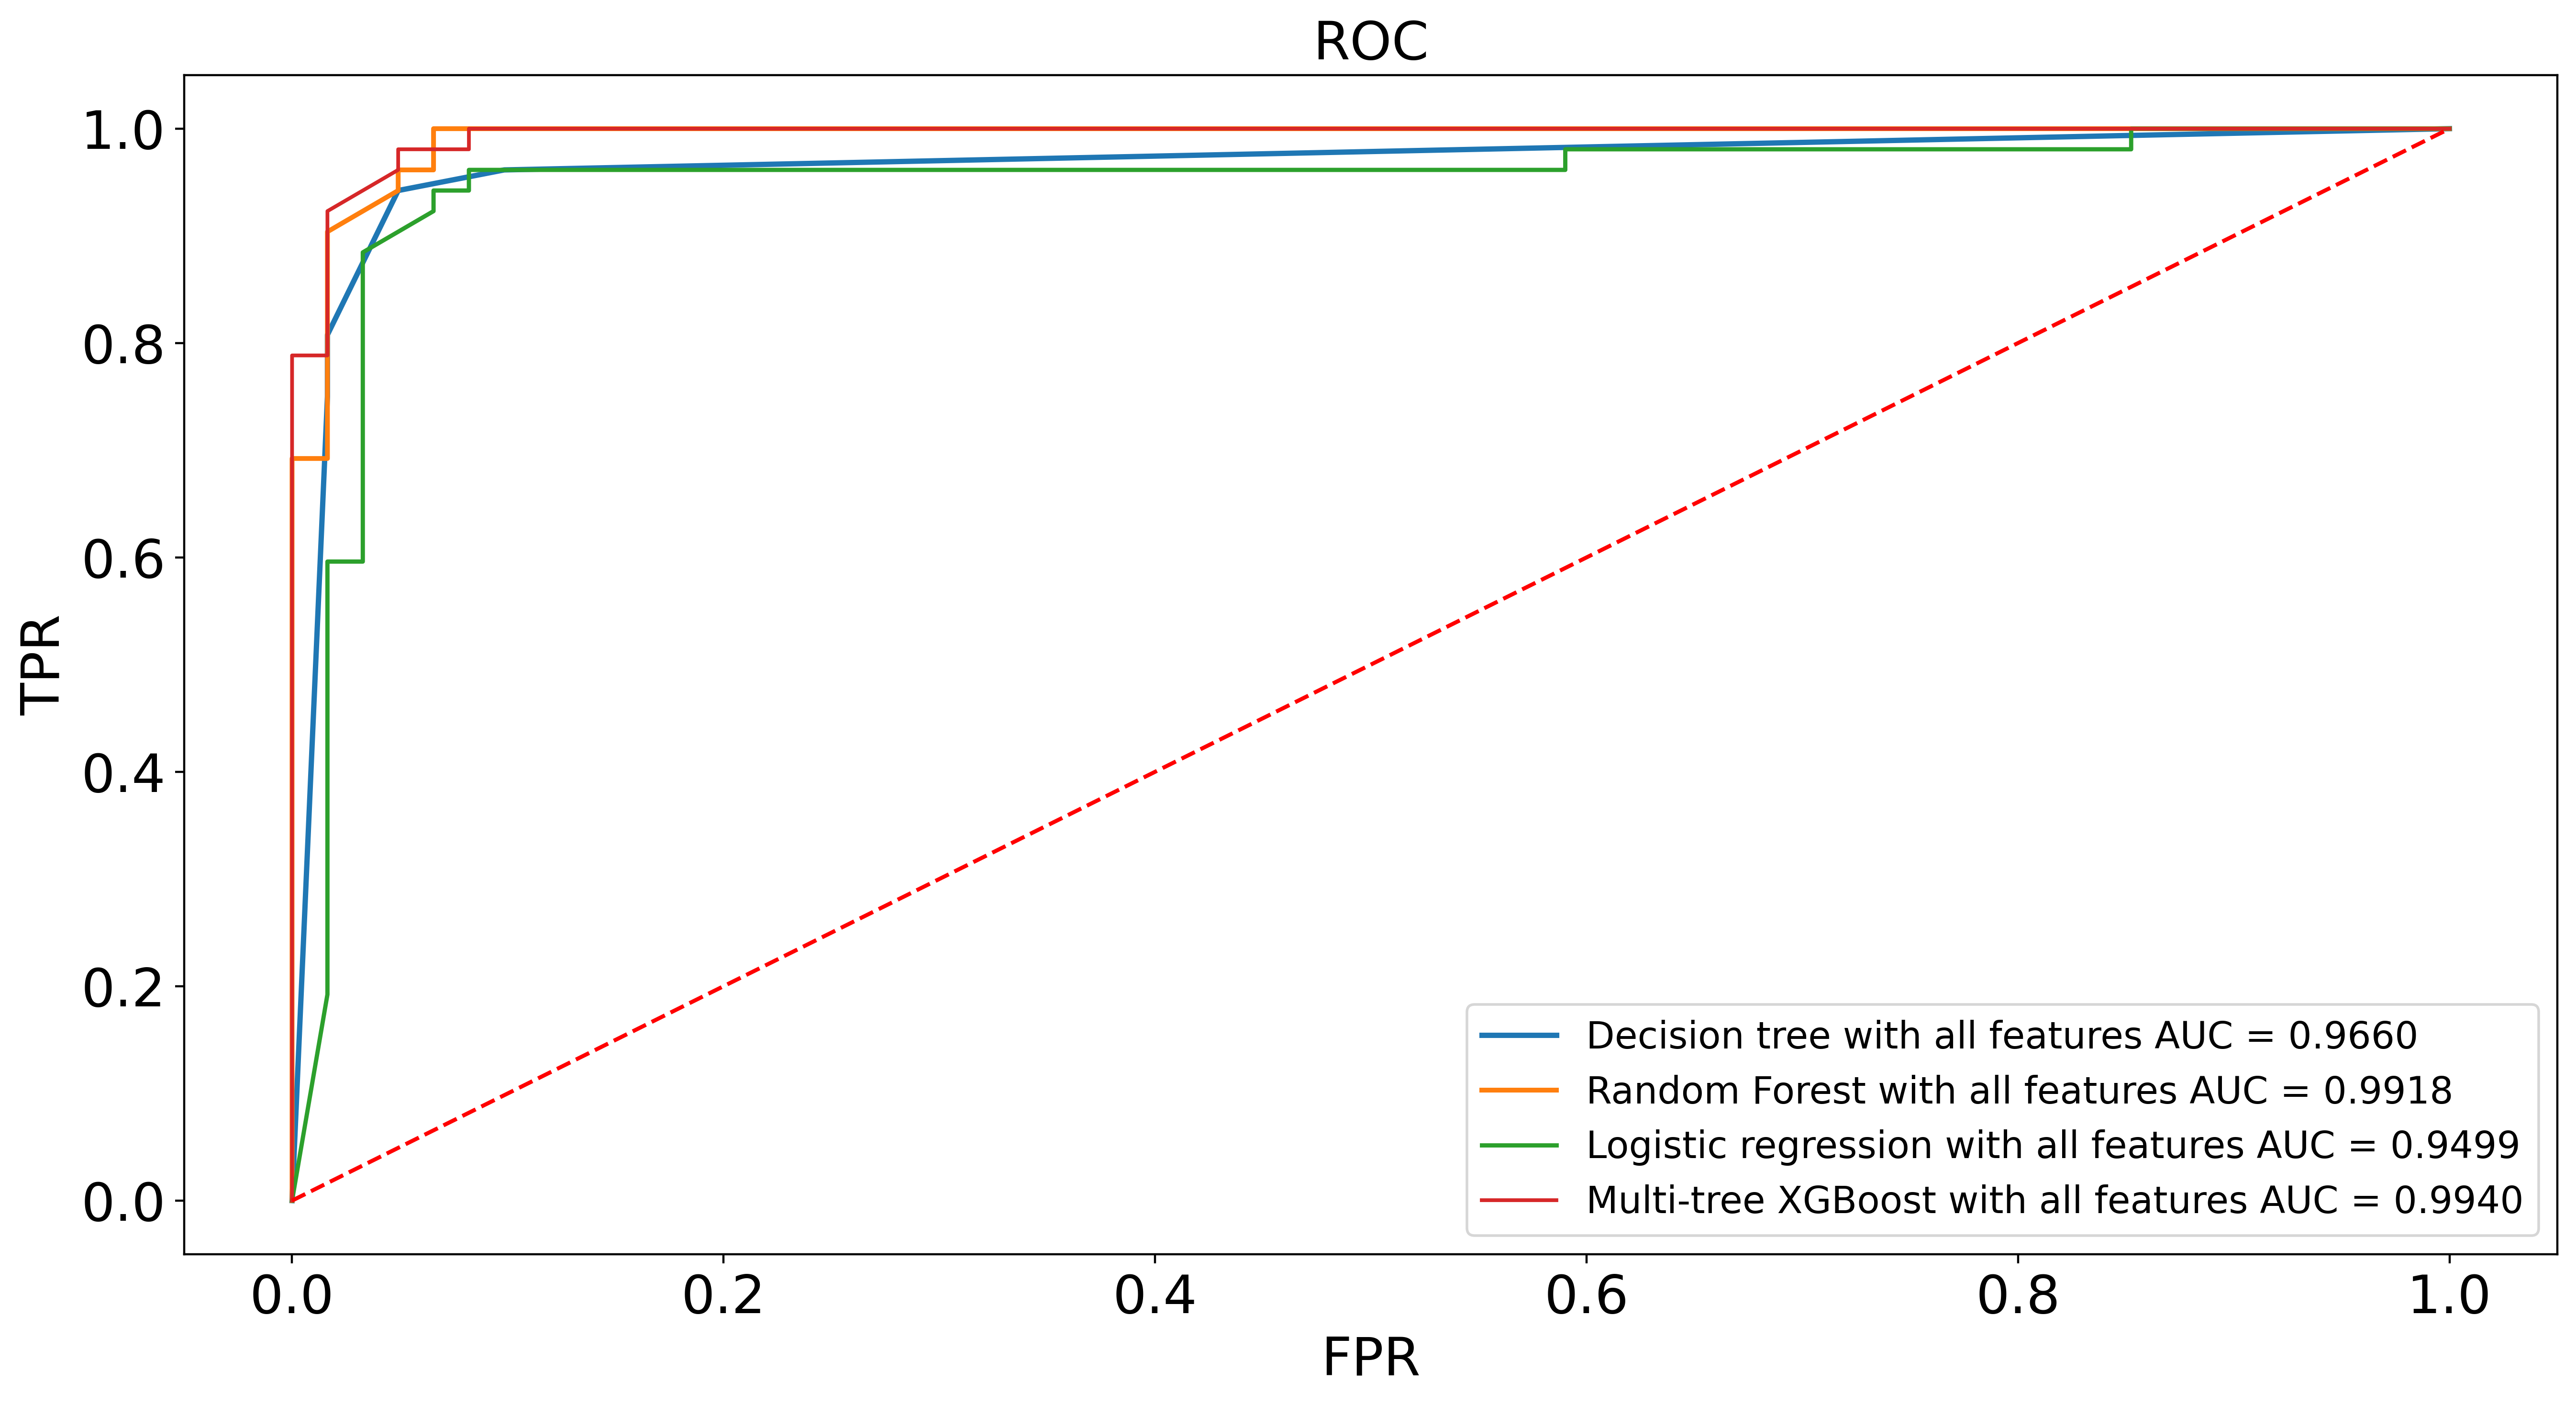

In [11]:
fig = plt.figure(dpi=400,figsize=(16, 8))

i = 0
for model in Model_name:
    plot_roc(y_val, pred_val[i], Model_name[i],fig,[],i)
    i += 1
    
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='best', fontsize=14)
plt.show()